# Overview - Population Time Series Data
### _Explore Time Series from the U.S. Census Bureau_
https://www.kaggle.com/census/population-time-series-data

This is a dataset from the U.S. Census Bureau hosted by the Federal Reserve Economic Database (FRED). FRED has a data platform found here and they update their information according the amount of data that is brought in. Explore the U.S. Census Bureau using Kaggle and all of the data sources available through the U.S. Census Bureau organization page!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import datetime
import os

# Data Preparation

In [2]:
dataframe = pd.read_csv('data/Population.csv')
dataframe = dataframe[['date','value']]

In [3]:
dataframe['date'] = pd.to_datetime(dataframe['date'])

In [4]:
dataframe.tail()

,date,value
811,2019-08-01,329591.333
812,2019-09-01,329785.872
813,2019-10-01,329982.035
814,2019-11-01,330154.949
815,2019-12-01,330309.946


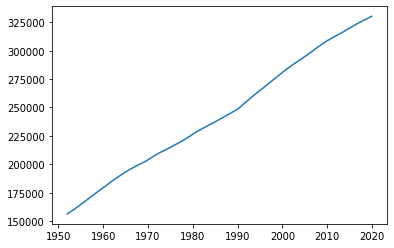

In [5]:
plt.plot(dataframe.date,dataframe.value)

# Data Preprocessing

In [6]:
def split_sequence(sequence, n_steps=3):
    sequence = list(sequence)
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    def reshape(d):
        d = np.array(d)
        d = np.reshape(d,(d.shape[0],d.shape[1],1))
        return d
    return reshape(X), np.array(y)

In [7]:
train_data = dataframe.value.iloc[:700]
test_data = dataframe.value.iloc[700:]

In [8]:
x_train,y_train = split_sequence(train_data)
x_test,y_test = split_sequence(test_data)

# RNN Model

In [9]:
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=(3,1,),activation='relu',return_sequences=True),
    keras.layers.LSTM(64,activation='relu'),
    keras.layers.Dense(1)
])

In [10]:
model.compile(loss='mse',optimizer='adam')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Callback & EarlyStopping

In [12]:
%load_ext tensorboard

In [13]:
os.makedirs('logs',exist_ok=True)
logdir = os.path.join('logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [14]:
callback = keras.callbacks.TensorBoard(logdir)
earlyStoping = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

# Training Model

In [15]:
history = model.fit(x_train,y_train,epochs=100,batch_size=32,callbacks=[callback,earlyStoping],verbose=2)

Train on 697 samples
Epoch 1/100
697/697 - 3s - loss: 51337519286.1750
Epoch 2/100
697/697 - 0s - loss: 44482877013.9455
Epoch 3/100
697/697 - 0s - loss: 38648620453.6471
Epoch 4/100
697/697 - 0s - loss: 32318714505.3659
Epoch 5/100
697/697 - 0s - loss: 22293193362.1808
Epoch 6/100
697/697 - 0s - loss: 11580412482.8465
Epoch 7/100
697/697 - 0s - loss: 2636001433.3888
Epoch 8/100
697/697 - 0s - loss: 60333177.1220
Epoch 9/100
697/697 - 0s - loss: 18187134.2621
Epoch 10/100
697/697 - 0s - loss: 1365048.5866
Epoch 11/100
697/697 - 0s - loss: 90784.5267
Epoch 12/100
697/697 - 0s - loss: 34548.2185
Epoch 13/100
697/697 - 0s - loss: 14028.9695
Epoch 14/100
697/697 - 0s - loss: 13287.1242
Epoch 15/100
697/697 - 0s - loss: 13242.8165
Epoch 16/100
697/697 - 0s - loss: 13230.9846
Epoch 17/100
697/697 - 0s - loss: 13272.1838
Epoch 18/100
697/697 - 0s - loss: 13252.7457
Epoch 19/100
697/697 - 0s - loss: 13225.8331
Epoch 20/100
697/697 - 0s - loss: 13280.9616
Epoch 21/100
697/697 - 0s - loss: 13267

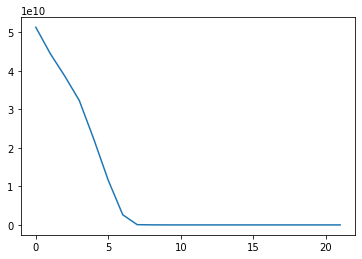

In [16]:
plt.plot(history.history['loss'])

# Demonstrate Prediction

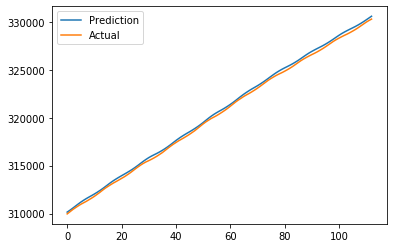

In [17]:
plt.plot(model.predict(x_test),label='Prediction')
plt.plot(y_test,label='Actual')
plt.legend()

# Future Prediction

In [18]:
def predict_future(shift_count):
    def reshape(three):
        return np.array(three).reshape(1,3,1) 
    array =  list(dataframe.value) + []
    now = len(dataframe)-3
    last = len(dataframe)
    for _ in range(shift_count):
        converted = reshape(array[now:last])
        array.append(model.predict(converted)[0][0])
        now += 1
        last += 1
    return array

In [19]:
future_prediction = predict_future(1000)

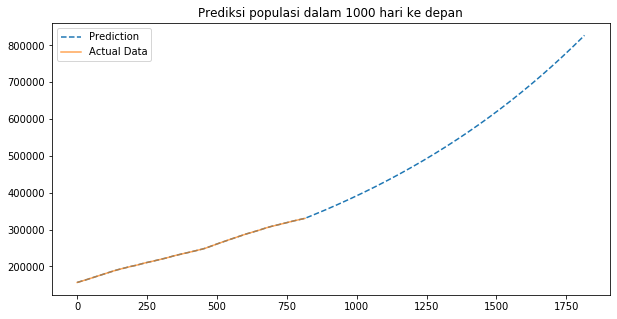

In [22]:
plt.figure(figsize=(10,5))
plt.plot(future_prediction,'--',label='Prediction')
plt.plot(dataframe.value,label='Actual Data',alpha=0.7)
plt.title('Prediksi populasi dalam 1000 hari ke depan')
plt.legend();